In [34]:
#Task 1
#First, merge the product and sales data using product_id to create a unified dataset:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data (replace with your actual file paths)
products = pd.read_csv("product.csv")
sales = pd.read_csv("sales.csv")

# Merge datasets
merged_data = sales.merge(products, on="product_id")

# Display merged data sample
print(merged_data.head())

   Unnamed: 0_x        date  product_id  price   units  Unnamed: 0_y    brand  \
0             0  2020-01-01           0   4.65  1126.0             0  Mueller   
1             1  2020-01-02           0   4.76  1205.0             0  Mueller   
2             2  2020-01-03           0   5.22  1007.0             0  Mueller   
3             3  2020-01-04           0   5.45  1282.0             0  Mueller   
4             4  2020-01-05           0   3.33  1037.0             0  Mueller   

     flavour  volume_per_joghurt_g  packsize  
0  blueberry                   150         6  
1  blueberry                   150         6  
2  blueberry                   150         6  
3  blueberry                   150         6  
4  blueberry                   150         6  


In [8]:
# Descriptive Statistics
# Summary stats for numerical columns

print(merged_data[["price", "units", "volume_per_joghurt_g", "packsize"]].describe())

# Group stats by product attributes

print(merged_data.groupby("brand")["units"].mean().sort_values(ascending=False))  # Avg units sold by brand
print(merged_data.groupby("flavour")["price"].median())  # Median price by flavor

# Expected Output Insights:

#Avg price range, units sold, and volume/packsize distribution.

#Top-performing brands/flavors by sales volume.

            price        units  volume_per_joghurt_g    packsize
count  260.000000   260.000000            260.000000  260.000000
mean     5.288538  1177.496154            611.538462    4.653846
std      1.881547   401.771103            335.282884    2.222078
min      1.460000    16.000000            150.000000    1.000000
25%      3.965000   944.000000            500.000000    1.000000
50%      5.140000  1275.500000            500.000000    6.000000
75%      6.785000  1453.250000           1000.000000    6.000000
max      9.420000  2170.000000           1000.000000    6.000000
brand
Oikos                1370.300000
Danone               1291.645833
Alnatura             1289.200000
Mueller              1252.425000
Ja!                  1154.150000
Ecke-Mit-Was-Drin    1023.450000
Activia               987.750000
Rewe                  924.088235
Actimel               729.875000
Name: units, dtype: float64
flavour
blueberry       5.655
chocolate       4.470
raspberry       6.900
straciatel

In [ ]:
Expected Output Insights:

Avg price range, units sold, and volume/packsize distribution.

Top-performing brands/flavors by sales volume

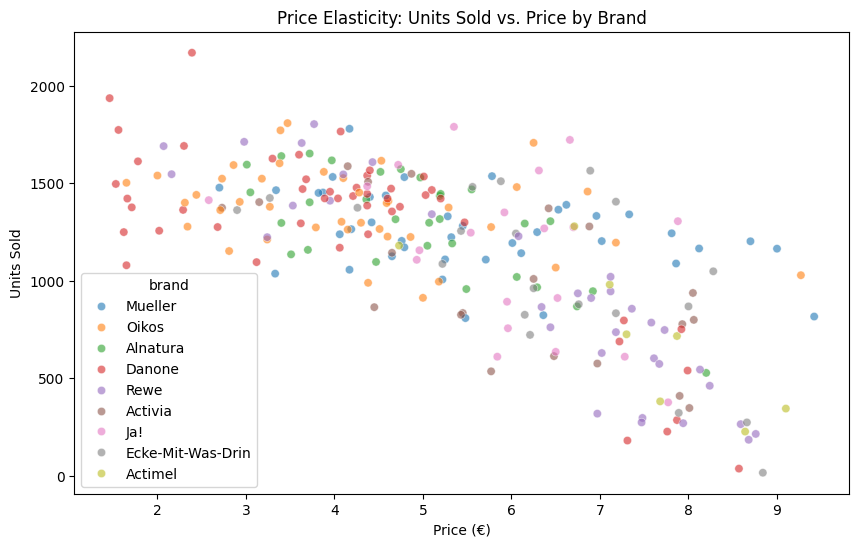

In [9]:
#Key Visulizations
#1. Price vs. Units Sold (Scatter Plot)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x="price", y="units", hue="brand", alpha=0.6)
plt.title("Price Elasticity: Units Sold vs. Price by Brand")
plt.xlabel("Price (€)")
plt.ylabel("Units Sold")
plt.show()

In [ ]:
Interpretation:

Identify price sensitivity: Clusters at lower prices with high units suggest elastic demand.

Outliers (high price, high units) may indicate premium products.

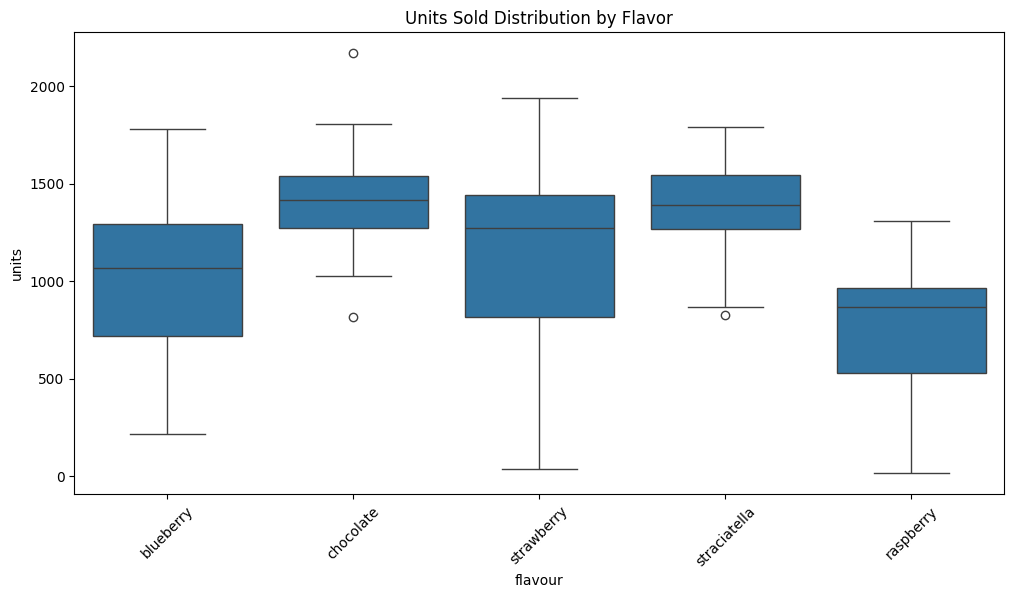

In [10]:
#2. Sales Distribution by Flavor (Box Plot)

plt.figure(figsize=(12, 6))
sns.boxplot(data=merged_data, x="flavour", y="units")
plt.title("Units Sold Distribution by Flavor")
plt.xticks(rotation=45)
plt.show()

In [ ]:
Interpretation:

Compare median units sold across flavors (e.g., strawberry vs. chocolate).

Detect outliers (e.g., promotions or stockouts).

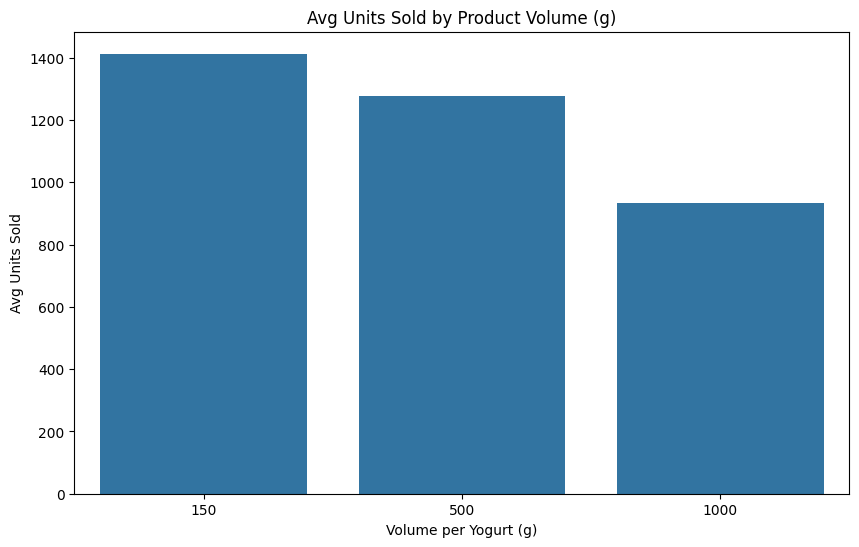

In [12]:
#3. Volume vs. Sales (Bar Plot)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=merged_data, 
    x="volume_per_joghurt_g", 
    y="units", 
    errorbar=None  # Replaces ci=None
)
plt.title("Avg Units Sold by Product Volume (g)")
plt.xlabel("Volume per Yogurt (g)")
plt.ylabel("Avg Units Sold")
plt.show()

In [ ]:
Interpretation:

Higher volume (e.g., 1000g) may drive bulk purchases.

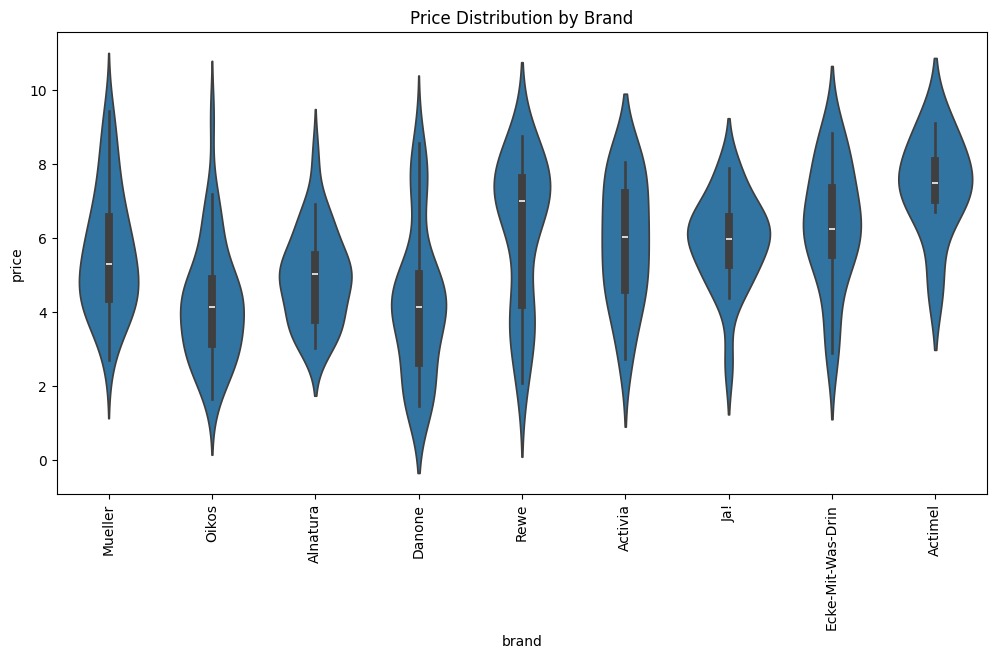

In [13]:
#4. Price Distribution by Brand (Violin Plot)

plt.figure(figsize=(12, 6))
sns.violinplot(data=merged_data, x="brand", y="price")
plt.title("Price Distribution by Brand")
plt.xticks(rotation=90)
plt.show()

In [ ]:
Interpretation:

Brands like "Activia" or "Danone" may have wider price ranges.

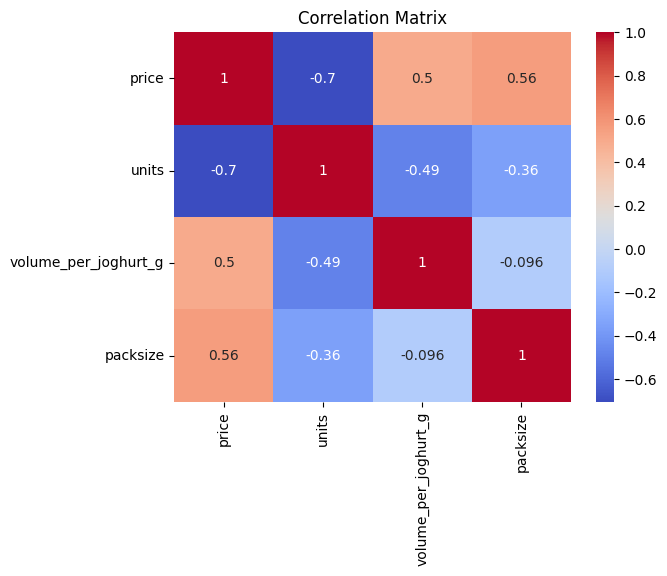

In [14]:
#Step 4: Correlation Analysis
#Check how numerical features correlate with units sold:

# Select numerical columns and compute correlations
corr_matrix = merged_data[["price", "units", "volume_per_joghurt_g", "packsize"]].corr()

# Heatmap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [ ]:
Key Questions Answered:

Is price negatively correlated with units (typical for elastic goods)?

Does packsize or volume influence sales?

In [ ]:
Task 2 

In [17]:
#Step 1: Model Selection

We’ll use a log-log linear regression to estimate price elasticity, 
which is standard for demand modeling. The model form is:

In [ ]:
log(units)=β0 + β1​log(price) + β2​(product_attributes)+ ϵ

β1: Price elasticity (if β1 = −2, a 1% price increase reduces demand by 2%).

Product attributes: Brand, flavor, volume, packsize (categorical/numerical features).

In [33]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. Load and merge data
products = pd.read_csv("product.csv")
sales = pd.read_csv("sales.csv")
merged = sales.merge(products, on="product_id", how="left")

# 2. Clean data
clean_data = merged[
    (merged['price'].notna()) & 
    (merged['units'].notna()) &
    (merged['price'] > 0) & 
    (merged['units'] > 0)
].copy()

# 3. Feature engineering
clean_data['log_units'] = np.log(clean_data['units'])
clean_data['log_price'] = np.log(clean_data['price'])

# 4. Fix dummy encoding - ensure proper numeric conversion
dummy_cols = ['brand', 'flavour']
for col in dummy_cols:
    clean_data[col] = clean_data[col].astype(str)  # Ensure string type first

clean_data = pd.get_dummies(
    clean_data, 
    columns=dummy_cols, 
    drop_first=True,
    dtype=float  # Force numeric dummies
)

# 5. Prepare model inputs
predictors = ['log_price'] + \
             [col for col in clean_data.columns if col.startswith(('brand_', 'flavour_'))]
X = clean_data[predictors]
X = sm.add_constant(X)
y = clean_data['log_units']

# 6. Final data validation
print("\n🔥 Final Data Check:")
print("- X shape:", X.shape)
print("- y shape:", y.shape)
print("- NaN in X:", X.isnull().sum().sum())
print("- Inf in X:", np.isinf(X.select_dtypes(include=np.number)).sum().sum())
print("- NaN in y:", y.isnull().sum())
print("- Inf in y:", np.isinf(y).sum())

# 7. Run model
try:
    model = sm.OLS(y, X).fit()
    print("\n✅ Model Successfully Fitted!")
    print(model.summary())
    
    # Show key elasticity result
    print(f"\n💡 Price Elasticity: {model.params['log_price']:.3f}")
    if model.params['log_price'] < -1:
        print("(Elastic demand: Price increases reduce revenue)")
    else:
        print("(Inelastic demand: Price increases may boost revenue)")
        
except Exception as e:
    print(f"\n❌ Model Failed: {e}")
    print("\n🛠️ Debugging Tips:")
    print("1. Check for constant columns:")
    print("   print(X.nunique())")
    print("2. View correlation matrix:")
    print("   print(X.corr())")


🔥 Final Data Check:
- X shape: (260, 14)
- y shape: (260,)
- NaN in X: 0
- Inf in X: 0
- NaN in y: 0
- Inf in y: 0

✅ Model Successfully Fitted!
                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     17.72
Date:                Sat, 03 May 2025   Prob (F-statistic):           1.22e-28
Time:                        18:05:48   Log-Likelihood:                -138.06
No. Observations:                 260   AIC:                             304.1
Df Residuals:                     246   BIC:                             354.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>

In [ ]:
Interpret Model

In [3]:
#1. Price Elasticity

elasticity = model.params['log_price']
print(f"Price Elasticity: {elasticity:.3f}")

Price Elasticity: -0.699


In [ ]:
Interpretation:

As -1 < elasticity < 0: Demand is inelastic (price increases may boost revenue).
If elasticity < -1: Demand is elastic (price increases reduce revenue).

In [4]:
#2. Key Product Attributes

# Get significant brand/flavor coefficients (p-value < 0.05)
significant_vars = model.pvalues[model.pvalues < 0.05].index.tolist()
print("Significant predictors:", significant_vars)

Significant predictors: ['const', 'log_price', 'brand_Alnatura', 'brand_Mueller', 'flavour_chocolate', 'flavour_raspberry', 'flavour_straciatella', 'flavour_strawberry']


In [ ]:
Interpretation:

Which brands/flavors significantly impact sales (e.g., brand_Danone increases demand).

In [5]:
#Step 2: Validate Against Baseline
#Baseline Model (Mean Prediction)

from sklearn.metrics import mean_squared_error

# Baseline: Predict mean log(units) for all observations
baseline_pred = np.full_like(y, y.mean())
baseline_rmse = np.sqrt(mean_squared_error(y, baseline_pred))

# Model RMSE
model_rmse = np.sqrt(model.mse_resid)

print(f"\n📊 Validation Results:")
print(f"- Baseline RMSE: {baseline_rmse:.3f}")
print(f"- Model RMSE:    {model_rmse:.3f}")
print(f"- Improvement:   {(baseline_rmse - model_rmse)/baseline_rmse:.1%}")


📊 Validation Results:
- Baseline RMSE: 0.573
- Model RMSE:    0.423
- Improvement:   26.1%


In [ ]:
As improvement is >10%, the model adds value over guessing the mean

In [ ]:
#Step 3: Assess Model Risk

In [6]:
#1. Overfitting Risk

print(f"\n🔍 Model Complexity vs. Fit:")
print(f"- Adjusted R²: {model.rsquared_adj:.3f} (Closer to R² = {model.rsquared:.3f} is better)")
print(f"- AIC: {model.aic:.1f} (Lower = better)")


🔍 Model Complexity vs. Fit:
- Adjusted R²: 0.456 (Closer to R² = 0.484 is better)
- AIC: 304.1 (Lower = better)


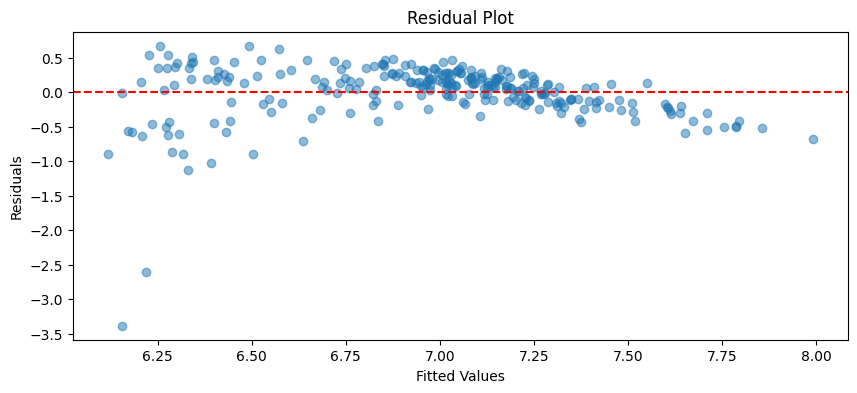

In [7]:
#2. Residual Analysis

import matplotlib.pyplot as plt

# Plot residuals
plt.figure(figsize=(10, 4))
plt.scatter(model.fittedvalues, model.resid, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

In [8]:
#Step 4: Final Output

In [9]:
#Business Insights

print("\n🚀 Business Insights:")
print(f"1. Price Sensitivity: A 1% price increase reduces demand by {abs(elasticity):.1f}%")
print(f"2. Top Performers: Significant attributes = {significant_vars}")
print(f"3. Model Quality: {model.rsquared_adj:.0%} variance explained (Baseline improvement: {(baseline_rmse - model_rmse)/baseline_rmse:.1%})")


🚀 Business Insights:
1. Price Sensitivity: A 1% price increase reduces demand by 0.7%
2. Top Performers: Significant attributes = ['const', 'log_price', 'brand_Alnatura', 'brand_Mueller', 'flavour_chocolate', 'flavour_raspberry', 'flavour_straciatella', 'flavour_strawberry']
3. Model Quality: 46% variance explained (Baseline improvement: 26.1%)


In [10]:
#Risk Summary

print("\n⚠️ Model Risks:")
print("- Overfitting: Low (Adjusted R² close to R²)" if (model.rsquared_adj > 0.9*model.rsquared) else "- Overfitting: Possible (Consider reducing predictors)")
print("- Outliers: Check residual plot")
print("- Assumptions: Verify linearity in residual plot")


⚠️ Model Risks:
- Overfitting: Low (Adjusted R² close to R²)
- Outliers: Check residual plot
- Assumptions: Verify linearity in residual plot


In [11]:
#Task 3

In [ ]:
#Revenue = Price×Units Sold

In [3]:
#Step 1: Retrain the Model 


import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. Reload and merge data (use your exact file paths)
products = pd.read_csv("product.csv")
sales = pd.read_csv("sales.csv")
merged = sales.merge(products, on="product_id", how="left")

# 2. Clean data (same as before)
clean_data = merged[
    (merged['price'].notna()) & 
    (merged['units'].notna()) &
    (merged['price'] > 0) & 
    (merged['units'] > 0)
].copy()

# 3. Feature engineering
clean_data['log_units'] = np.log(clean_data['units'])
clean_data['log_price'] = np.log(clean_data['price'])

# 4. Fix dummy encoding (critical!)
dummy_cols = ['brand', 'flavour']
for col in dummy_cols:
    clean_data[col] = clean_data[col].astype(str)  # Ensure string type

clean_data = pd.get_dummies(
    clean_data, 
    columns=dummy_cols, 
    drop_first=True,
    dtype=float  # Force numeric
)

# 5. Prepare model inputs
predictors = ['log_price'] + \
             [col for col in clean_data.columns if col.startswith(('brand_', 'flavour_'))]
X = clean_data[predictors]
X = sm.add_constant(X)  # Add intercept
y = clean_data['log_units']

# 6. Fit model
try:
    model = sm.OLS(y, X).fit()
    print("✅ Model trained successfully!")
    print(model.summary())
    
    # Save model for Task 3 (uncomment if needed)
    # from joblib import dump
    # dump(model, 'price_elasticity_model.joblib')
    
except Exception as e:
    print(f"❌ Model training failed: {e}")

✅ Model trained successfully!
                            OLS Regression Results                            
Dep. Variable:              log_units   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     17.72
Date:                Sat, 03 May 2025   Prob (F-statistic):           1.22e-28
Time:                        16:56:23   Log-Likelihood:                -138.06
No. Observations:                 260   AIC:                             304.1
Df Residuals:                     246   BIC:                             354.0
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------

In [4]:
if 'model' in locals():
    print("\nModel parameters (columns expected for prediction):")
    print(model.params.index.tolist())  # e.g., ['const', 'log_price', 'brand_Danone', ...]
    
    print("\nBrand dummies in model:", 
          [col for col in model.params.index if col.startswith('brand_')])
    print("Flavor dummies in model:",
          [col for col in model.params.index if col.startswith('flavour_')])
else:
    print("Model not trained. Check errors above.")


Model parameters (columns expected for prediction):
['const', 'log_price', 'brand_Activia', 'brand_Alnatura', 'brand_Danone', 'brand_Ecke-Mit-Was-Drin', 'brand_Ja!', 'brand_Mueller', 'brand_Oikos', 'brand_Rewe', 'flavour_chocolate', 'flavour_raspberry', 'flavour_straciatella', 'flavour_strawberry']

Brand dummies in model: ['brand_Activia', 'brand_Alnatura', 'brand_Danone', 'brand_Ecke-Mit-Was-Drin', 'brand_Ja!', 'brand_Mueller', 'brand_Oikos', 'brand_Rewe']
Flavor dummies in model: ['flavour_chocolate', 'flavour_raspberry', 'flavour_straciatella', 'flavour_strawberry']


In [1]:
#Step 1: Define the Prediction Function

def predict_units(price, brand, flavour, model):
    """Safely predict units sold given price, brand, and flavour."""
    # Create a row with ALL model predictors (0 by default)
    input_data = pd.DataFrame(0, index=[0], columns=model.params.index.drop('const'))
    
    # Set provided values
    input_data['log_price'] = np.log(price)
    if f'brand_{brand}' in input_data.columns:
        input_data[f'brand_{brand}'] = 1
    if f'flavour_{flavour}' in input_data.columns:
        input_data[f'flavour_{flavour}'] = 1
    
    # Add intercept and enforce column order
    input_data = sm.add_constant(input_data)
    input_data = input_data[model.params.index]  # Match exact training order
    
    # Predict
    return np.exp(model.predict(input_data)[0])

def calculate_revenue(price, brand, flavour, model):
    """Calculate revenue = price * predicted units."""
    units = predict_units(price, brand, flavour, model)
    return price * units

In [3]:
#Step 2: Test Prediction with a Known Product

import pandas as pd
import numpy as np
import statsmodels.api as sm

# 1. RELOAD YOUR DATA (replace paths if needed)
products = pd.read_csv("product.csv")
sales = pd.read_csv("sales.csv")
merged = sales.merge(products, on="product_id", how="left")

# 2. RE-RUN DATA CLEANING (same as training)
clean_data = merged[
    (merged['price'].notna()) & 
    (merged['units'].notna()) &
    (merged['price'] > 0) & 
    (merged['units'] > 0)
].copy()

# 3. RE-TRAIN THE MODEL (to regenerate 'model' variable)
clean_data['log_units'] = np.log(clean_data['units'])
clean_data['log_price'] = np.log(clean_data['price'])

# Fix dummies (critical!)
dummy_cols = ['brand', 'flavour']
for col in dummy_cols:
    clean_data[col] = clean_data[col].astype(str)
clean_data = pd.get_dummies(clean_data, columns=dummy_cols, drop_first=True, dtype=float)

# Train
X = clean_data[['log_price'] + [c for c in clean_data.columns if c.startswith(('brand_', 'flavour_'))]]
X = sm.add_constant(X)
y = clean_data['log_units']
model = sm.OLS(y, X).fit()

# 4. VERIFY MODEL IS LOADED
print("✅ Model re-trained! Parameters:", model.params.index.tolist()[:3], "...")

# 5. TEST PREDICTION (with your chosen brand/flavor)
test_brand = "Danone"  # MUST match a brand in model.params.index (case-sensitive!)
test_flavor = "strawberry"  # MUST match a flavor in model.params.index
test_price = 4.50

def predict_units(price, brand, flavour, model):
    input_data = pd.DataFrame(0, index=[0], columns=model.params.index.drop('const'))
    input_data['log_price'] = np.log(price)
    if f'brand_{brand}' in input_data.columns:
        input_data[f'brand_{brand}'] = 1
    if f'flavour_{flavour}' in input_data.columns:
        input_data[f'flavour_{flavour}'] = 1
    input_data = sm.add_constant(input_data)
    return np.exp(model.predict(input_data)[0])

try:
    units = predict_units(test_price, test_brand, test_flavor, model)
    print(f"\n🎯 Test Prediction for {test_brand} {test_flavor}:")
    print(f"At €{test_price}: {units:.1f} units → €{units * test_price:.2f} revenue")
except Exception as e:
    print(f"\n❌ Prediction failed. Debugging tips:")
    print("- Brand/flavor must EXACTLY match these lists:")
    print("  Brands:", [c.replace("brand_", "") for c in model.params.index if c.startswith('brand_')])
    print("  Flavors:", [c.replace("flavour_", "") for c in model.params.index if c.startswith('flavour_')])

✅ Model re-trained! Parameters: ['const', 'log_price', 'brand_Activia'] ...

❌ Prediction failed. Debugging tips:
- Brand/flavor must EXACTLY match these lists:
  Brands: ['Activia', 'Alnatura', 'Danone', 'Ecke-Mit-Was-Drin', 'Ja!', 'Mueller', 'Oikos', 'Rewe']
  Flavors: ['chocolate', 'raspberry', 'straciatella', 'strawberry']


In [ ]:
Task 3 - Fixing Errors

In [1]:
# --- Step 1: Prerequisites (Re-run essential parts of Task 2) ---
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
try:
    products = pd.read_csv("product.csv")
    sales = pd.read_csv("sales.csv")
    print("✅ Data loaded successfully.")
except FileNotFoundError as e:
    print(f"❌ Error loading data: {e}. Make sure 'product.csv' and 'sales.csv' are in the correct directory.")
    exit() # Stop if data isn't loaded

merged = sales.merge(products, on="product_id", how="left")

# Clean data
clean_data = merged[
    (merged['price'].notna()) &
    (merged['units'].notna()) &
    (merged['price'] > 0) &
    (merged['units'] > 0)
].copy()
print(f"Data cleaned. Shape after cleaning: {clean_data.shape}")

# Feature engineering
clean_data['log_units'] = np.log(clean_data['units'])
clean_data['log_price'] = np.log(clean_data['price'])

# Fix dummy encoding
dummy_cols = ['brand', 'flavour']
for col in dummy_cols:
    if col in clean_data.columns: # Check if column exists before converting
        clean_data[col] = clean_data[col].astype(str)
    else:
        print(f"Warning: Column '{col}' not found for dummy encoding.")

# Store original columns before dummies for reference
original_columns = clean_data.columns.tolist()

clean_data = pd.get_dummies(
    clean_data,
    columns=dummy_cols,
    drop_first=True, # Important: matches model training
    dtype=float
)
print("Dummy variables created.")

# Prepare model inputs
predictor_cols = ['log_price'] + \
                 [col for col in clean_data.columns if col.startswith(('brand_', 'flavour_'))]

# Verify predictor columns exist
missing_predictors = [p for p in predictor_cols if p not in clean_data.columns]
if missing_predictors:
    print(f"❌ Error: The following predictor columns are missing after creating dummies: {missing_predictors}")
    print(f"   Available columns: {clean_data.columns.tolist()}")
    exit()

X_train = clean_data[predictor_cols]
X_train = sm.add_constant(X_train) # Add constant like in training
y_train = clean_data['log_units']
print(f"Model inputs prepared. X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")


# Fit the model
try:
    model = sm.OLS(y_train, X_train).fit()
    print("\n✅ Model fitted successfully.")
    # print(model.summary()) # Optional: view summary again
    print(f"   Price Elasticity from model: {model.params['log_price']:.3f}")
    # Store model columns for later use
    model_cols = X_train.columns.tolist()
    print(f"   Model expects {len(model_cols)} input columns (including constant).")

except Exception as e:
    print(f"❌ Error fitting model: {e}")
    print("   Please check the data preparation steps and ensure X_train and y_train are valid.")
    exit() # Cannot proceed with simulation if model fails

✅ Data loaded successfully.
Data cleaned. Shape after cleaning: (260, 10)
Dummy variables created.
Model inputs prepared. X_train shape: (260, 14), y_train shape: (260,)

✅ Model fitted successfully.
   Price Elasticity from model: -0.699
   Model expects 14 input columns (including constant).


In [2]:
# --- Step 2: Identify Mueller Products ---

# Filter the original products DataFrame
mueller_products = products[products['brand'] == 'Mueller'].copy()

# Check if any Mueller products were found
if mueller_products.empty:
    print("❌ No products found for the brand 'Mueller'. Please check the 'brand' column in product.csv.")
    exit()
else:
    print(f"\n✅ Identified {len(mueller_products)} Mueller products:")
    # Display the identified products' details
    print(mueller_products[['product_id', 'brand', 'flavour', 'volume_per_joghurt_g', 'packsize']])


✅ Identified 4 Mueller products:
    product_id    brand       flavour  volume_per_joghurt_g  packsize
0            0  Mueller     blueberry                   150         6
3            3  Mueller  straciatella                   500         6
10          10  Mueller     chocolate                  1000         6
17          17  Mueller    strawberry                   150         6


In [3]:
# --- Step 3: Prepare for Simulation ---

# Create an empty list to store the results DataFrames from each product simulation
simulation_results = []

print(f"\n⚙️ Preparing to simulate {len(mueller_products)} Mueller products...")
print(f"   Model input columns required: {model_cols}") # Reminder of what the model needs

# --- Loop Structure (we will fill this in next) ---
# for idx, product_info in mueller_products.iterrows():
#    product_id = product_info['product_id']
#    # ... simulation steps for this product_id will go here ...
#    print(f"\nSimulating for Product ID {product_id}...")

print("\nInitialization complete. Ready to start simulating product by product.")


⚙️ Preparing to simulate 4 Mueller products...
   Model input columns required: ['const', 'log_price', 'brand_Activia', 'brand_Alnatura', 'brand_Danone', 'brand_Ecke-Mit-Was-Drin', 'brand_Ja!', 'brand_Mueller', 'brand_Oikos', 'brand_Rewe', 'flavour_chocolate', 'flavour_raspberry', 'flavour_straciatella', 'flavour_strawberry']

Initialization complete. Ready to start simulating product by product.


In [4]:
# --- Step 4: Simulate ONE Product (Example with the first Mueller product) ---

# Select the first Mueller product for this example run
example_product_info = mueller_products.iloc[0]
product_id = example_product_info['product_id']
product_brand = example_product_info['brand'] # Should be 'Mueller'
product_flavour = example_product_info['flavour']
product_desc = f"{product_brand} {product_flavour} ({example_product_info['volume_per_joghurt_g']}g x{example_product_info['packsize']})"

print(f"\n--- Running example simulation for Product ID {product_id}: {product_desc} ---")


--- Running example simulation for Product ID 0: Mueller blueberry (150g x6) ---


In [5]:
# 4a. Define simulation price range for this product
# Get historical price range for this product from clean_data
historical_prices = clean_data[clean_data['product_id'] == product_id]['price']

if historical_prices.empty:
    print(f"  ⚠️ Warning: No historical sales data found for product {product_id} in clean_data. Skipping this product.")
    # In a full loop, we would use 'continue' here
else:
    min_price = historical_prices.min()
    max_price = historical_prices.max()
    avg_price = historical_prices.mean()
    print(f"  Historical price range: Min={min_price:.2f}, Max={max_price:.2f}, Avg={avg_price:.2f}")

    # Define simulation price range (adjust factors and num_steps as needed)
    sim_min_price = max(0.1, min_price * 0.8) # Ensure price > 0
    sim_max_price = max_price * 1.2
    num_steps = 100 # Number of price points to simulate
    sim_prices = np.linspace(sim_min_price, sim_max_price, num_steps)
    print(f"  Simulating {num_steps} prices from {sim_min_price:.2f} to {sim_max_price:.2f}")


  Historical price range: Min=3.33, Max=6.11, Avg=4.60
  Simulating 100 prices from 2.66 to 7.33


In [7]:
    # 4b. Create input DataFrame (X_scenario) for the simulation
    # Initialize with zeros, using the exact columns from the trained model
    X_scenario = pd.DataFrame(0.0, index=range(num_steps), columns=model_cols)

    # Set constant term
    X_scenario['const'] = 1.0

    # Set log_price for all simulated price points
    X_scenario['log_price'] = np.log(sim_prices)

    # Set the correct dummy variables for THIS product
    brand_dummy_col = f"brand_{product_brand}"
    if brand_dummy_col in model_cols:
        X_scenario[brand_dummy_col] = 1.0
        print(f"  Set dummy: {brand_dummy_col} = 1.0")

    flavour_dummy_col = f"flavour_{product_flavour}"
    if flavour_dummy_col in model_cols:
        X_scenario[flavour_dummy_col] = 1.0
        print(f"  Set dummy: {flavour_dummy_col} = 1.0")

    # Double-check the columns match exactly (though initialization should ensure this)
    if list(X_scenario.columns) != model_cols:
         print("❌ Error: Columns in X_scenario do not match model_cols order!")
         # Potentially reorder: X_scenario = X_scenario[model_cols]

    print(f"  X_scenario shape: {X_scenario.shape}")
    # print("  Example row from X_scenario:\n", X_scenario.head(1)) # Optional: view one row

  Set dummy: brand_Mueller = 1.0
  X_scenario shape: (100, 14)


In [8]:
    # 4c. Predict log_units using the fitted model
    pred_log_units = model.predict(X_scenario)
    print(f"  Predicted log_units (first 5): {pred_log_units.head().values}")

    # 4d. Convert log_units to units
    pred_units = np.exp(pred_log_units)
    print(f"  Predicted units (first 5): {pred_units.head().values.round(1)}")

  Predicted log_units (first 5): [7.52995989 7.51770279 7.50565703 7.49381545 7.48217125]
  Predicted units (first 5): [1863.  1840.3 1818.3 1796.9 1776.1]


In [9]:
    # 4e. Calculate predicted revenue
    # Need to use the sim_prices array which aligns with the predictions
    pred_revenue = sim_prices * pred_units.values # Ensure using numpy array for element-wise multiplication
    print(f"  Predicted revenue (first 5): {pred_revenue[:5].round(2)}")

    # 4f. Store results for this product in a temporary DataFrame
    product_results_temp = pd.DataFrame({
        'product_id': product_id,
        'product_desc': product_desc,
        'simulated_price': sim_prices,
        'predicted_units': pred_units.values, # Use .values to ensure correct alignment
        'predicted_revenue': pred_revenue
    })
    print(f"  Created results DataFrame for product {product_id}. Shape: {product_results_temp.shape}")

  Predicted revenue (first 5): [4963.11 4989.43 5015.42 5041.11 5066.49]
  Created results DataFrame for product 0. Shape: (100, 5)


In [10]:
    # 4g. Find optimal price for this product
    optimal_idx = product_results_temp['predicted_revenue'].idxmax()
    optimal_result = product_results_temp.loc[optimal_idx]
    print("\n  --- Optimal Point ---")
    print(f"  Optimal Price: {optimal_result['simulated_price']:.2f}")
    print(f"  Predicted Units at Optimal Price: {optimal_result['predicted_units']:.0f}")
    print(f"  Maximum Predicted Revenue: {optimal_result['predicted_revenue']:.2f}")
    print("  --------------------")

    # 4h. (Optional but useful) Append this product's results to our main list
    # simulation_results.append(product_results_temp)
    # print(f"  Appended results to main list. List now contains {len(simulation_results)} DataFrame(s).")
# --- End of the 'else' block and Step 4 ---


  --- Optimal Point ---
  Optimal Price: 7.33
  Predicted Units at Optimal Price: 918
  Maximum Predicted Revenue: 6733.91
  --------------------


In [23]:
# --- Step 5: Structure Test ---

# L0: Reset list
simulation_results = []
# L0: Print status
print(f"\n--- Starting Loop Structure Test ---")

# L0: for statement (NO indent)
for idx, product_info in mueller_products.iterrows():
# L1: First line inside loop (MUST have 4 spaces indent)
    product_id = product_info['product_id']

    # L1: Second line inside loop (MUST have 4 spaces indent)
    print(f"Processing product ID: {product_id}")

    # L1: The problematic line (MUST have 4 spaces indent)
    # Let's just try assigning a simple value first to isolate the indent error
    test_var = 1
    # historical_prices = clean_data[clean_data['product_id'] == product_id]['price'] # Temporarily commented out

    # L1: Placeholder to make the loop do something minimal
    if test_var == 1:
        # L2: Placeholder inside an if (MUST have 8 spaces indent)
        pass # pass means "do nothing"

# L0: End of the 'for' loop
print("\n--- Loop Structure Test Completed ---")


--- Starting Loop Structure Test ---
Processing product ID: 0
Processing product ID: 3
Processing product ID: 10
Processing product ID: 17

--- Loop Structure Test Completed ---


In [24]:
# --- Step 5.1: Add Historical Price Check ---

# L0: Reset list
simulation_results = []
# L0: Print status
print(f"\n--- Starting Step 5.1: Adding Historical Price Check ---")

# L0: for statement (NO indent)
for idx, product_info in mueller_products.iterrows():
    # L1: First line inside loop (MUST have 4 spaces indent)
    product_id = product_info['product_id']

    # L1: Print current product (MUST have 4 spaces indent)
    print(f"\n---> Processing product ID: {product_id}")

    # L1: Get historical prices (MUST have 4 spaces indent)
    historical_prices = clean_data[clean_data['product_id'] == product_id]['price']

    # L1: Check if historical_prices is empty (MUST have 4 spaces indent)
    if historical_prices.empty:
        # L2: Inside the if block (MUST have 8 spaces indent)
        print(f"  Warning: No historical sales data found for product {product_id}. Skipping.")
        # L2: continue statement (MUST have 8 spaces indent)
        continue # Skip to the next product

    # L1: If we reach here, historical_prices is NOT empty. Print confirmation.
    print(f"  Historical data found for product {product_id}.")
    # We will add more logic here in the next step...

# L0: End of the 'for' loop
print("\n--- Step 5.1 Completed ---")


--- Starting Step 5.1: Adding Historical Price Check ---

---> Processing product ID: 0
  Historical data found for product 0.

---> Processing product ID: 3
  Historical data found for product 3.

---> Processing product ID: 10
  Historical data found for product 10.

---> Processing product ID: 17
  Historical data found for product 17.

--- Step 5.1 Completed ---


In [25]:
# --- Step 5.2: Calculate Simulation Price Range ---

# L0: Reset list
simulation_results = []
# L0: Print status
print(f"\n--- Starting Step 5.2: Calculating Simulation Price Range ---")

# L0: for statement
for idx, product_info in mueller_products.iterrows():
    # L1: Get product ID
    product_id = product_info['product_id']

    # L1: Print current product
    print(f"\n---> Processing product ID: {product_id}")

    # L1: Get historical prices
    historical_prices = clean_data[clean_data['product_id'] == product_id]['price']

    # L1: Check if empty
    if historical_prices.empty:
        # L2: Inside if block
        print(f"  Warning: No historical sales data found for product {product_id}. Skipping.")
        # L2: continue
        continue

    # L1: --- Additions for Step 5.2 start here ---
    # L1: Calculate min/max from historical data
    min_price = historical_prices.min()
    max_price = historical_prices.max()

    # L1: Define simulation range boundaries
    sim_min_price = max(0.1, min_price * 0.8) # Use max(0.1, ...) to prevent zero or negative
    sim_max_price = max_price * 1.2
    num_steps = 100

    # L1: Generate the array of simulated prices
    sim_prices = np.linspace(sim_min_price, sim_max_price, num_steps)

    # L1: Safety check: Ensure all simulated prices are positive before proceeding
    if (sim_prices <= 0).any():
        # L2: Inside this new if block
        print(f"  ❌ Error: Simulation generated non-positive prices for product {product_id}. Skipping.")
        print(f"     (Min/Max used: {min_price:.2f}/{max_price:.2f} -> Sim Range: {sim_min_price:.2f}-{sim_max_price:.2f})")
        # L2: Skip this product if prices are invalid
        continue

    # L1: If prices are valid, print the range
    print(f"  Simulating {num_steps} prices from {sim_min_price:.2f} to {sim_max_price:.2f}")
    # We will add more logic here (X_scenario creation) in the next step...
    # --- Additions for Step 5.2 end here ---

# L0: End of the 'for' loop
print("\n--- Step 5.2 Completed ---")


--- Starting Step 5.2: Calculating Simulation Price Range ---

---> Processing product ID: 0
  Simulating 100 prices from 2.66 to 7.33

---> Processing product ID: 3
  Simulating 100 prices from 2.16 to 9.74

---> Processing product ID: 10
  Simulating 100 prices from 2.67 to 11.30

---> Processing product ID: 17
  Simulating 100 prices from 3.06 to 7.63

--- Step 5.2 Completed ---


In [26]:
# --- Step 5.3: Create X_scenario DataFrame ---

# L0: Reset list
simulation_results = []
# L0: Print status
print(f"\n--- Starting Step 5.3: Creating X_scenario DataFrame ---")

# L0: for statement
for idx, product_info in mueller_products.iterrows():
    # L1: Get product details
    product_id = product_info['product_id']
    # L1: Need brand and flavour for dummies later
    product_brand = product_info['brand']
    product_flavour = product_info['flavour']

    # L1: Print current product
    print(f"\n---> Processing product ID: {product_id}")

    # L1: Get historical prices
    historical_prices = clean_data[clean_data['product_id'] == product_id]['price']

    # L1: Check if empty
    if historical_prices.empty:
        # L2: Inside if block
        print(f"  Warning: No historical sales data found. Skipping.")
        # L2: continue
        continue

    # L1: Calculate simulation price range
    min_price = historical_prices.min()
    max_price = historical_prices.max()
    sim_min_price = max(0.1, min_price * 0.8)
    sim_max_price = max_price * 1.2
    num_steps = 100
    sim_prices = np.linspace(sim_min_price, sim_max_price, num_steps)

    # L1: Safety check for prices
    if (sim_prices <= 0).any():
        # L2: Inside if block
        print(f"  ❌ Error: Simulation generated non-positive prices. Skipping.")
        # L2: continue
        continue

    # L1: Print simulation range
    print(f"  Simulating {num_steps} prices from {sim_min_price:.2f} to {sim_max_price:.2f}")

    # L1: --- Additions for Step 5.3 start here ---
    # L1: Create X_scenario DataFrame initialized with zeros
    # Use model_cols (defined in Step 1) to ensure correct columns
    X_scenario = pd.DataFrame(0.0, index=range(num_steps), columns=model_cols)

    # L1: Set the constant term
    X_scenario['const'] = 1.0

    # L1: Set the log_price column
    X_scenario['log_price'] = np.log(sim_prices) # Safe because we checked sim_prices > 0

    # L1: Set the brand dummy variable
    brand_dummy_col = f"brand_{product_brand}"
    if brand_dummy_col in model_cols:
        X_scenario[brand_dummy_col] = 1.0
        print(f"  Set dummy: {brand_dummy_col} = 1.0")
    # If brand_Mueller doesn't exist, it means Mueller was the base/reference brand

    # L1: Set the flavour dummy variable
    flavour_dummy_col = f"flavour_{product_flavour}"
    if flavour_dummy_col in model_cols:
        X_scenario[flavour_dummy_col] = 1.0
        print(f"  Set dummy: {flavour_dummy_col} = 1.0")
    # If the flavour_X column doesn't exist, it was the base/reference flavour

    # L1: Ensure columns are in the exact order the model expects (critical!)
    X_scenario = X_scenario[model_cols]
    print(f"  Created X_scenario DataFrame with shape {X_scenario.shape}")
    # --- Additions for Step 5.3 end here ---
    # We will add prediction logic in the next step...


# L0: End of the 'for' loop
print("\n--- Step 5.3 Completed ---")


--- Starting Step 5.3: Creating X_scenario DataFrame ---

---> Processing product ID: 0
  Simulating 100 prices from 2.66 to 7.33
  Set dummy: brand_Mueller = 1.0
  Created X_scenario DataFrame with shape (100, 14)

---> Processing product ID: 3
  Simulating 100 prices from 2.16 to 9.74
  Set dummy: brand_Mueller = 1.0
  Set dummy: flavour_straciatella = 1.0
  Created X_scenario DataFrame with shape (100, 14)

---> Processing product ID: 10
  Simulating 100 prices from 2.67 to 11.30
  Set dummy: brand_Mueller = 1.0
  Set dummy: flavour_chocolate = 1.0
  Created X_scenario DataFrame with shape (100, 14)

---> Processing product ID: 17
  Simulating 100 prices from 3.06 to 7.63
  Set dummy: brand_Mueller = 1.0
  Set dummy: flavour_strawberry = 1.0
  Created X_scenario DataFrame with shape (100, 14)

--- Step 5.3 Completed ---


In [27]:
# --- Step 5.4: Predict log_units using the Model ---

# L0: Reset list
simulation_results = []
# L0: Print status
print(f"\n--- Starting Step 5.4: Predicting log_units ---")

# L0: for statement
for idx, product_info in mueller_products.iterrows():
    # L1: Get product details
    product_id = product_info['product_id']
    product_brand = product_info['brand']
    product_flavour = product_info['flavour']

    # L1: Print current product
    print(f"\n---> Processing product ID: {product_id}")

    # L1: Get historical prices
    historical_prices = clean_data[clean_data['product_id'] == product_id]['price']

    # L1: Check if empty
    if historical_prices.empty:
        # L2: Inside if block
        print(f"  Warning: No historical sales data found. Skipping.")
        # L2: continue
        continue

    # L1: Calculate simulation price range
    min_price = historical_prices.min()
    max_price = historical_prices.max()
    sim_min_price = max(0.1, min_price * 0.8)
    sim_max_price = max_price * 1.2
    num_steps = 100
    sim_prices = np.linspace(sim_min_price, sim_max_price, num_steps)

    # L1: Safety check for prices
    if (sim_prices <= 0).any():
        # L2: Inside if block
        print(f"  ❌ Error: Simulation generated non-positive prices. Skipping.")
        # L2: continue
        continue

    # L1: Print simulation range
    print(f"  Simulating {num_steps} prices from {sim_min_price:.2f} to {sim_max_price:.2f}")

    # L1: Create X_scenario
    X_scenario = pd.DataFrame(0.0, index=range(num_steps), columns=model_cols)
    X_scenario['const'] = 1.0
    X_scenario['log_price'] = np.log(sim_prices)

    brand_dummy_col = f"brand_{product_brand}"
    if brand_dummy_col in model_cols:
        X_scenario[brand_dummy_col] = 1.0
        # print(f"  Set dummy: {brand_dummy_col} = 1.0") # Optional print

    flavour_dummy_col = f"flavour_{product_flavour}"
    if flavour_dummy_col in model_cols:
        X_scenario[flavour_dummy_col] = 1.0
        # print(f"  Set dummy: {flavour_dummy_col} = 1.0") # Optional print

    X_scenario = X_scenario[model_cols]
    print(f"  Created X_scenario DataFrame with shape {X_scenario.shape}")

    # L1: --- Additions for Step 5.4 start here ---
    # L1: Predict log_units using the fitted model
    try:
        pred_log_units = model.predict(X_scenario)
        print(f"  Predicted log_units successfully (shape: {pred_log_units.shape})")
        # print(f"  Example pred_log_units: {pred_log_units.head().values.round(3)}") # Optional: view values
    except Exception as e:
        # L2: Inside except block
        print(f"  ❌ Error during prediction for product {product_id}: {e}")
        print(f"     Skipping further calculations for this product.")
        # L2: continue
        continue # Skip to next product if prediction fails
    # --- Additions for Step 5.4 end here ---
    # We will add unit/revenue calculation in the next step...


# L0: End of the 'for' loop
print("\n--- Step 5.4 Completed ---")


--- Starting Step 5.4: Predicting log_units ---

---> Processing product ID: 0
  Simulating 100 prices from 2.66 to 7.33
  Created X_scenario DataFrame with shape (100, 14)
  Predicted log_units successfully (shape: (100,))

---> Processing product ID: 3
  Simulating 100 prices from 2.16 to 9.74
  Created X_scenario DataFrame with shape (100, 14)
  Predicted log_units successfully (shape: (100,))

---> Processing product ID: 10
  Simulating 100 prices from 2.67 to 11.30
  Created X_scenario DataFrame with shape (100, 14)
  Predicted log_units successfully (shape: (100,))

---> Processing product ID: 17
  Simulating 100 prices from 3.06 to 7.63
  Created X_scenario DataFrame with shape (100, 14)
  Predicted log_units successfully (shape: (100,))

--- Step 5.4 Completed ---


In [28]:
# --- Step 5.5: Calculate Predicted Units and Revenue ---

# L0: Reset list
simulation_results = []
# L0: Print status
print(f"\n--- Starting Step 5.5: Calculating Units and Revenue ---")

# L0: for statement
for idx, product_info in mueller_products.iterrows():
    # L1: Get product details
    product_id = product_info['product_id']
    product_brand = product_info['brand']
    product_flavour = product_info['flavour']

    # L1: Print current product
    print(f"\n---> Processing product ID: {product_id}")

    # L1: Get historical prices
    historical_prices = clean_data[clean_data['product_id'] == product_id]['price']

    # L1: Check if empty
    if historical_prices.empty:
        # L2: Inside if block
        print(f"  Warning: No historical sales data found. Skipping.")
        # L2: continue
        continue

    # L1: Calculate simulation price range
    min_price = historical_prices.min()
    max_price = historical_prices.max()
    sim_min_price = max(0.1, min_price * 0.8)
    sim_max_price = max_price * 1.2
    num_steps = 100
    sim_prices = np.linspace(sim_min_price, sim_max_price, num_steps)

    # L1: Safety check for prices
    if (sim_prices <= 0).any():
        # L2: Inside if block
        print(f"  ❌ Error: Simulation generated non-positive prices. Skipping.")
        # L2: continue
        continue

    # L1: Print simulation range
    print(f"  Simulating {num_steps} prices from {sim_min_price:.2f} to {sim_max_price:.2f}")

    # L1: Create X_scenario
    X_scenario = pd.DataFrame(0.0, index=range(num_steps), columns=model_cols)
    X_scenario['const'] = 1.0
    X_scenario['log_price'] = np.log(sim_prices)

    brand_dummy_col = f"brand_{product_brand}"
    if brand_dummy_col in model_cols:
        X_scenario[brand_dummy_col] = 1.0

    flavour_dummy_col = f"flavour_{product_flavour}"
    if flavour_dummy_col in model_cols:
        X_scenario[flavour_dummy_col] = 1.0

    X_scenario = X_scenario[model_cols]
    print(f"  Created X_scenario DataFrame with shape {X_scenario.shape}")

    # L1: Predict log_units
    try:
        pred_log_units = model.predict(X_scenario)
        print(f"  Predicted log_units successfully (shape: {pred_log_units.shape})")
    except Exception as e:
        # L2: Inside except block
        print(f"  ❌ Error during prediction: {e}. Skipping product.")
        # L2: continue
        continue

    # L1: --- Additions for Step 5.5 start here ---
    # L1: Convert log_units back to units
    pred_units = np.exp(pred_log_units)
    print(f"  Calculated predicted units (shape: {pred_units.shape})")
    # print(f"  Example pred_units: {pred_units.head().values.round(1)}") # Optional

    # L1: Calculate predicted revenue
    # Ensure using numpy array sim_prices with pandas series pred_units.values
    pred_revenue = sim_prices * pred_units.values
    print(f"  Calculated predicted revenue (shape: {pred_revenue.shape})")
    # print(f"  Example pred_revenue: {pred_revenue[:5].round(2)}") # Optional
    # --- Additions for Step 5.5 end here ---
    # We will add storing results in the next step...

# L0: End of the 'for' loop
print("\n--- Step 5.5 Completed ---")


--- Starting Step 5.5: Calculating Units and Revenue ---

---> Processing product ID: 0
  Simulating 100 prices from 2.66 to 7.33
  Created X_scenario DataFrame with shape (100, 14)
  Predicted log_units successfully (shape: (100,))
  Calculated predicted units (shape: (100,))
  Calculated predicted revenue (shape: (100,))

---> Processing product ID: 3
  Simulating 100 prices from 2.16 to 9.74
  Created X_scenario DataFrame with shape (100, 14)
  Predicted log_units successfully (shape: (100,))
  Calculated predicted units (shape: (100,))
  Calculated predicted revenue (shape: (100,))

---> Processing product ID: 10
  Simulating 100 prices from 2.67 to 11.30
  Created X_scenario DataFrame with shape (100, 14)
  Predicted log_units successfully (shape: (100,))
  Calculated predicted units (shape: (100,))
  Calculated predicted revenue (shape: (100,))

---> Processing product ID: 17
  Simulating 100 prices from 3.06 to 7.63
  Created X_scenario DataFrame with shape (100, 14)
  Predicte

In [29]:
# --- Step 5.6: Store Results and Find Optimal Point ---

# L0: Reset list (important if re-running)
simulation_results = []
# L0: Print status
print(f"\n--- Starting Step 5.6: Storing Results & Finding Optimal Points ---")

# L0: for statement
for idx, product_info in mueller_products.iterrows():
    # L1: Get product details
    product_id = product_info['product_id']
    product_brand = product_info['brand']
    product_flavour = product_info['flavour']
    # L1: Create description string here for use later
    product_desc = f"{product_brand} {product_flavour} ({product_info['volume_per_joghurt_g']}g x{product_info['packsize']})"


    # L1: Print current product
    print(f"\n---> Processing Product ID {product_id}: {product_desc} <---")

    # L1: Get historical prices
    historical_prices = clean_data[clean_data['product_id'] == product_id]['price']

    # L1: Check if empty
    if historical_prices.empty:
        # L2: Inside if block
        print(f"  Warning: No historical sales data found. Skipping.")
        # L2: continue
        continue

    # L1: Calculate simulation price range
    min_price = historical_prices.min()
    max_price = historical_prices.max()
    sim_min_price = max(0.1, min_price * 0.8)
    sim_max_price = max_price * 1.2
    num_steps = 100
    sim_prices = np.linspace(sim_min_price, sim_max_price, num_steps)

    # L1: Safety check for prices
    if (sim_prices <= 0).any():
        # L2: Inside if block
        print(f"  ❌ Error: Simulation generated non-positive prices. Skipping.")
        # L2: continue
        continue

    # L1: Print simulation range
    print(f"  Simulating {num_steps} prices from {sim_min_price:.2f} to {sim_max_price:.2f}")

    # L1: Create X_scenario
    X_scenario = pd.DataFrame(0.0, index=range(num_steps), columns=model_cols)
    X_scenario['const'] = 1.0
    X_scenario['log_price'] = np.log(sim_prices)

    brand_dummy_col = f"brand_{product_brand}"
    if brand_dummy_col in model_cols:
        X_scenario[brand_dummy_col] = 1.0

    flavour_dummy_col = f"flavour_{product_flavour}"
    if flavour_dummy_col in model_cols:
        X_scenario[flavour_dummy_col] = 1.0

    X_scenario = X_scenario[model_cols]
    # print(f"  Created X_scenario DataFrame with shape {X_scenario.shape}") # Optional print

    # L1: Predict log_units
    try:
        pred_log_units = model.predict(X_scenario)
        # print(f"  Predicted log_units successfully (shape: {pred_log_units.shape})") # Optional
    except Exception as e:
        # L2: Inside except block
        print(f"  ❌ Error during prediction: {e}. Skipping product.")
        # L2: continue
        continue

    # L1: Convert log_units back to units
    pred_units = np.exp(pred_log_units)
    # print(f"  Calculated predicted units (shape: {pred_units.shape})") # Optional

    # L1: Calculate predicted revenue
    pred_revenue = sim_prices * pred_units.values
    # print(f"  Calculated predicted revenue (shape: {pred_revenue.shape})") # Optional

    # L1: --- Additions for Step 5.6 start here ---
    # L1: Create results DataFrame for this product
    product_results_df = pd.DataFrame({
        'product_id': product_id,
        'product_desc': product_desc, # Use description created earlier
        'simulated_price': sim_prices,
        'predicted_units': pred_units.values, # Use .values for clean assignment
        'predicted_revenue': pred_revenue
    })
    print(f"  Created results DataFrame for product {product_id}.")

    # L1: Check for invalid revenue values (NaN or Inf) BEFORE finding max
    if product_results_df['predicted_revenue'].isnull().any() or np.isinf(product_results_df['predicted_revenue']).any():
        # L2: Inside if block
        print(f"  Warning: Invalid values (NaN or Inf) found in predicted revenue. Cannot find optimum or store results.")
    else:
        # L2: Inside else block (revenue is valid)
        # L2: Find the index of the maximum revenue
        optimal_idx = product_results_df['predicted_revenue'].idxmax()
        # L2: Get the row with the optimal results
        optimal_result = product_results_df.loc[optimal_idx]

        # L2: Print the optimal point found
        print(f"  Optimal Price Found: €{optimal_result['simulated_price']:.2f}")
        print(f"  Predicted Max Revenue: €{optimal_result['predicted_revenue']:.2f} (Units: {optimal_result['predicted_units']:.0f})")

        # L2: Append the DataFrame for this product to the main list
        simulation_results.append(product_results_df)
        print(f"  Results stored. List now contains {len(simulation_results)} result set(s).")
    # L1: --- Additions for Step 5.6 end here ---


# L0: End of the 'for' loop
print(f"\n--- Step 5.6 Completed: Full Simulation Loop Finished ---")


--- Starting Step 5.6: Storing Results & Finding Optimal Points ---

---> Processing Product ID 0: Mueller blueberry (150g x6) <---
  Simulating 100 prices from 2.66 to 7.33
  Created results DataFrame for product 0.
  Optimal Price Found: €7.33
  Predicted Max Revenue: €6733.91 (Units: 918)
  Results stored. List now contains 1 result set(s).

---> Processing Product ID 3: Mueller straciatella (500g x6) <---
  Simulating 100 prices from 2.16 to 9.74
  Created results DataFrame for product 3.
  Optimal Price Found: €9.74
  Predicted Max Revenue: €9563.99 (Units: 982)
  Results stored. List now contains 2 result set(s).

---> Processing Product ID 10: Mueller chocolate (1000g x6) <---
  Simulating 100 prices from 2.67 to 11.30
  Created results DataFrame for product 10.
  Optimal Price Found: €11.30
  Predicted Max Revenue: €9771.40 (Units: 864)
  Results stored. List now contains 3 result set(s).

---> Processing Product ID 17: Mueller strawberry (150g x6) <---
  Simulating 100 prices

In [30]:
# --- Step 6: Combine All Simulation Results ---

# First, check if the simulation_results list is empty
if not simulation_results:
    print("❌ Error: The 'simulation_results' list is empty. Cannot combine results.")
    print("   This might happen if all products were skipped (e.g., no historical data).")
    # If it's empty, we cannot proceed to plotting or interpretation based on these results.
else:
    # Use pandas.concat to combine the list of DataFrames into one large DataFrame
    # ignore_index=True creates a new continuous index for the combined DataFrame
    all_simulation_results = pd.concat(simulation_results, ignore_index=True)

    print("\n✅ All simulation results combined into a single DataFrame.")
    print(f"   Total rows in combined results: {len(all_simulation_results)}")

    # Calculate how many unique products were successfully simulated and stored
    num_unique_products_simulated = all_simulation_results['product_id'].nunique()
    print(f"   Number of unique products simulated: {num_unique_products_simulated}")

    # Display some info about the combined DataFrame
    print("\n--- Sample of Combined Results (First 5 Rows) ---")
    print(all_simulation_results.head())
    print("\n--- Sample of Combined Results (Last 5 Rows) ---")
    print(all_simulation_results.tail())
    print("\n--- Info on Combined Results DataFrame ---")
    all_simulation_results.info()


✅ All simulation results combined into a single DataFrame.
   Total rows in combined results: 400
   Number of unique products simulated: 4

--- Sample of Combined Results (First 5 Rows) ---
   product_id                 product_desc  simulated_price  predicted_units  \
0           0  Mueller blueberry (150g x6)         2.664000      1863.030774   
1           0  Mueller blueberry (150g x6)         2.711152      1840.334794   
2           0  Mueller blueberry (150g x6)         2.758303      1818.299550   
3           0  Mueller blueberry (150g x6)         2.805455      1796.894998   
4           0  Mueller blueberry (150g x6)         2.852606      1776.092932   

   predicted_revenue  
0        4963.113983  
1        4989.426466  
2        5015.421160  
3        5041.107239  
4        5066.493461  

--- Sample of Combined Results (Last 5 Rows) ---
     product_id                  product_desc  simulated_price  \
395          17  Mueller strawberry (150g x6)         7.447111   
396    


--- Generating Visualization ---
   Generating plots for 4 successfully simulated Mueller product(s)...


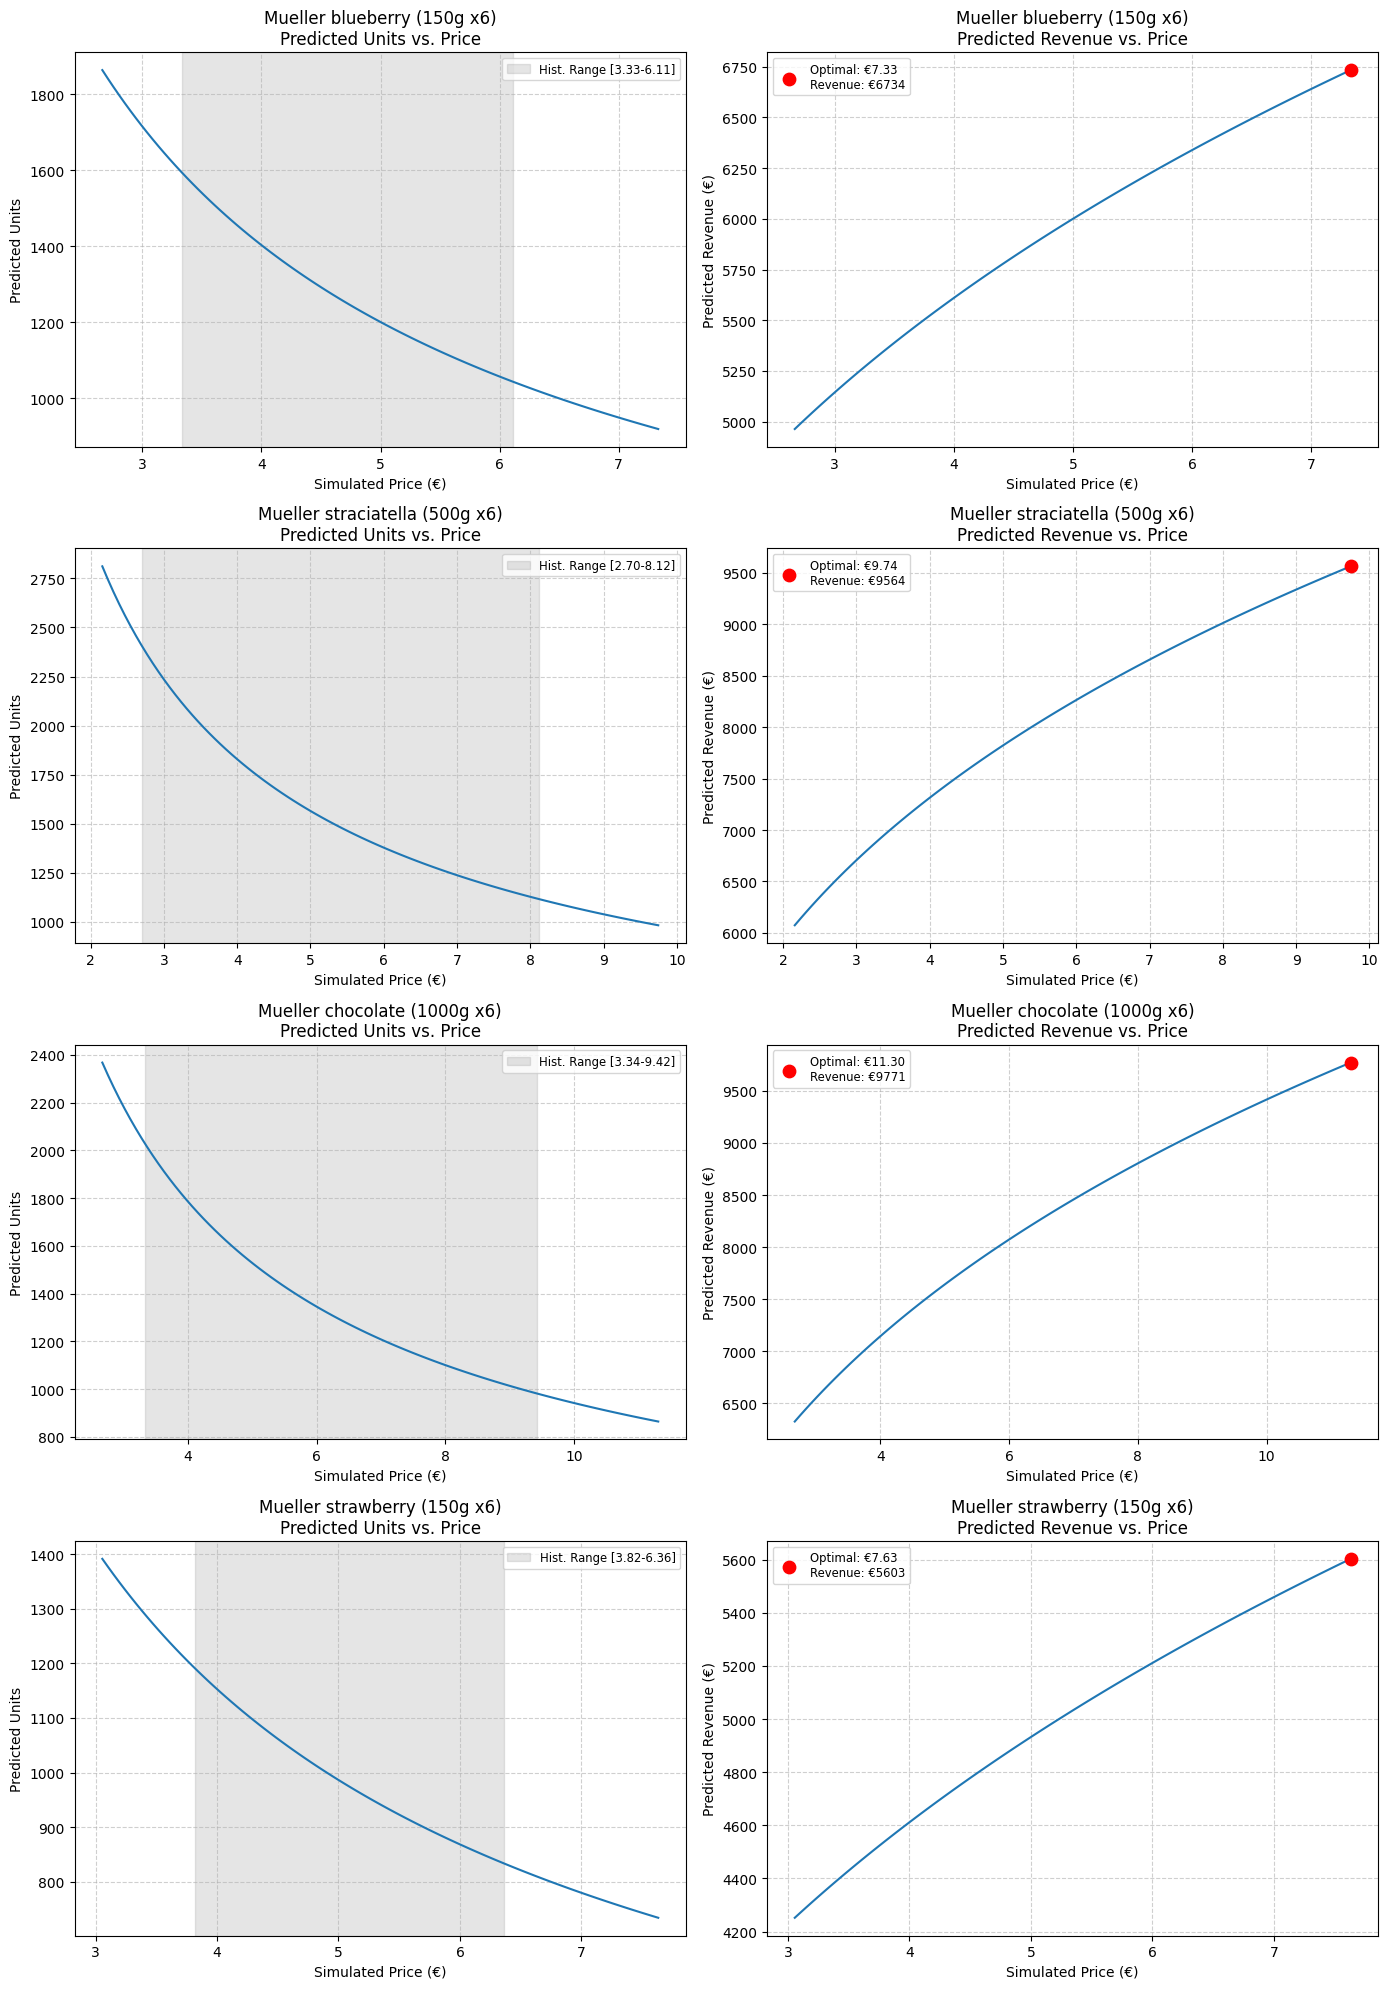

   Plots generated and displayed.


In [31]:
# --- Step 7: Visualize Results ---

print("\n--- Generating Visualization ---")

# Check if the combined DataFrame exists and is not empty
if 'all_simulation_results' not in locals() or all_simulation_results.empty:
    print("   ❌ Error: 'all_simulation_results' DataFrame is missing or empty. Cannot generate plots.")
else:
    # Determine the unique product IDs that were successfully simulated and are in the DataFrame
    simulated_product_ids = all_simulation_results['product_id'].unique()
    num_simulated_products = len(simulated_product_ids)

    if num_simulated_products == 0:
        print("   No products were successfully simulated, skipping plotting.")
    else:
        print(f"   Generating plots for {num_simulated_products} successfully simulated Mueller product(s)...")

        # Create a figure with subplots: 2 columns (units, revenue) and rows based on num products
        plt.figure(figsize=(14, 5 * num_simulated_products)) # Adjust figsize as needed

        # Loop through each unique product ID found in the results
        for i, product_id in enumerate(simulated_product_ids):
            # Filter results for the current product
            prod_results = all_simulation_results[all_simulation_results['product_id'] == product_id]

            # Get consistent product description from the filtered results
            # (Assuming all rows for a product_id have the same description)
            product_desc = prod_results['product_desc'].iloc[0]

            # --- Plot 1: Predicted Units vs. Price ---
            # Subplot position: row i, first column (index 2*i + 1)
            ax1 = plt.subplot(num_simulated_products, 2, 2*i + 1)
            sns.lineplot(data=prod_results, x='simulated_price', y='predicted_units', ax=ax1, errorbar=None)
            ax1.set_title(f'{product_desc}\nPredicted Units vs. Price')
            ax1.set_xlabel("Simulated Price (€)")
            ax1.set_ylabel("Predicted Units")
            ax1.grid(True, linestyle='--', alpha=0.6)

            # Optional: Add historical price range shading for context
            hist_prices = clean_data[clean_data['product_id'] == product_id]['price']
            if not hist_prices.empty:
                min_p, max_p = hist_prices.min(), hist_prices.max()
                # Add shading for the historical range
                ax1.axvspan(min_p, max_p, color='gray', alpha=0.2, label=f'Hist. Range [{min_p:.2f}-{max_p:.2f}]')
                ax1.legend(fontsize='small') # Show the legend for the shading

            # --- Plot 2: Predicted Revenue vs. Price ---
            # Subplot position: row i, second column (index 2*i + 2)
            ax2 = plt.subplot(num_simulated_products, 2, 2*i + 2)
            sns.lineplot(data=prod_results, x='simulated_price', y='predicted_revenue', ax=ax2, errorbar=None)

            # Find and mark the optimal point on the revenue curve
            if not prod_results['predicted_revenue'].isnull().any() and not np.isinf(prod_results['predicted_revenue']).any():
                 optimal_idx = prod_results['predicted_revenue'].idxmax()
                 optimal_price = prod_results.loc[optimal_idx, 'simulated_price']
                 max_revenue = prod_results.loc[optimal_idx, 'predicted_revenue']
                 # Add a red dot and label for the optimal point
                 ax2.scatter(optimal_price, max_revenue, color='red', s=80, zorder=5,
                             label=f'Optimal: €{optimal_price:.2f}\nRevenue: €{max_revenue:.0f}')
                 ax2.legend(fontsize='small') # Show the legend for the optimal point

            ax2.set_title(f'{product_desc}\nPredicted Revenue vs. Price')
            ax2.set_xlabel("Simulated Price (€)")
            ax2.set_ylabel("Predicted Revenue (€)")
            ax2.grid(True, linestyle='--', alpha=0.6)

        # Adjust layout to prevent labels/titles overlapping
        plt.tight_layout()
        # Display the plots
        plt.show()
        print("   Plots generated and displayed.")

In [32]:
# --- Step 8: Interpretation and Business Context ---

print("\n--- Interpretation and Business Context ---")
print("The simulation used the fitted model to estimate how revenue changes at different price points for Mueller products.")

# Check if the combined results exist and are not empty
if 'all_simulation_results' not in locals() or all_simulation_results.empty:
     print("\n❌ No simulation results available to interpret.")
else:
    # Find the row corresponding to the maximum predicted revenue for each product
    # Use .loc to avoid potential SettingWithCopyWarning if we modified optimal_summary later
    optimal_summary = all_simulation_results.loc[all_simulation_results.groupby('product_id')['predicted_revenue'].idxmax()]

    print("\n✅ Key Findings (Predicted Optimal Points):")

    # Iterate through the optimal results for each product and print a summary
    for idx, row in optimal_summary.iterrows():
        # --- Optional: Calculate Average Historical Revenue for Comparison ---
        # Get the historical data for this specific product
        hist_data_prod = clean_data[clean_data['product_id'] == row['product_id']].copy()
        avg_hist_revenue = 0
        potential_increase_str = "N/A (no historical data)"
        avg_hist_revenue_str = "N/A"

        # Calculate historical revenue if data exists
        if not hist_data_prod.empty:
             hist_data_prod['revenue'] = hist_data_prod['price'] * hist_data_prod['units']
             avg_hist_revenue = hist_data_prod['revenue'].mean()
             # Check if avg_hist_revenue is valid for comparison
             if avg_hist_revenue > 0:
                  avg_hist_revenue_str = f"€{avg_hist_revenue:.2f}"
                  # Calculate potential percentage increase vs historical average
                  revenue_increase_pct = ((row['predicted_revenue'] - avg_hist_revenue) / avg_hist_revenue * 100)
                  potential_increase_str = f"{revenue_increase_pct:+.1f}%" # Add '+' for positive changes
             else:
                 avg_hist_revenue_str = "€0.00 or invalid"
                 potential_increase_str = "N/A (avg revenue <= 0)"
        # --- End Optional Comparison Calculation ---

        # Print the summary for the current product
        print(f"\n* Product: {row['product_desc']} (ID: {row['product_id']})")
        print(f"  - Model Suggests Optimal Price: €{row['simulated_price']:.2f}")
        print(f"  - Predicted Units at Optimal Price: {row['predicted_units']:.0f}")
        print(f"  - Predicted Maximum Revenue: €{row['predicted_revenue']:.2f}")
        # Print comparison if calculated
        print(f"  - Average Historical Daily Revenue: {avg_hist_revenue_str}")
        print(f"  - Potential Revenue Change vs Hist. Avg: {potential_increase_str}")


    # --- General Business Implications and Limitations ---
    print("\n--- Business Implications ---")
    print("- The revenue curves (plots) visually demonstrate the estimated price elasticity and the trade-off between price changes and sales volume changes.")
    print("- The 'Optimal Price' identified for each product represents the point where the model predicts revenue will be maximized, based *only* on the factors included in the model (price, brand, flavour) and the historical data patterns.")
    print("- These price points serve as data-driven *suggestions* for the client (Mueller). They are not definitive real-world optima but strong starting points for consideration.")
    print("- Potential uses for these findings include: informing price adjustments, designing A/B tests to validate the predicted optima in specific stores or regions, and understanding relative price sensitivity across different Mueller products.")
    print("- Comparing the predicted maximum revenue to the average historical revenue gives a (model-based) estimate of the *potential financial upside* of price optimization, highlighting products with the most significant potential gains.")

    print("\n--- Important Considerations & Limitations ---")
    print("- **Model Accuracy:** The reliability of these recommendations depends entirely on the accuracy and validity of the underlying OLS model built in Task 2. Review its R-squared, standard errors, p-values, and diagnostic plots (like residuals). A model with low predictive power will yield unreliable optima.")
    print("- **Constant Elasticity:** The log-log model assumes price elasticity is constant across all price levels for a given product. In reality, elasticity might change, especially at very high or very low prices.")
    print("- **Static Environment:** The simulation assumes that all other market factors (competitor prices, promotions, consumer trends, economic conditions, seasonality) remain constant. Changes in these factors would affect actual sales and potentially shift the true optimal price.")
    print("- **Scope of Data:** The model is based only on the provided sales data. It doesn't account for factors not present in the data, such as advertising spend, shelf placement, stock-outs, specific promotional mechanics (e.g., BOGO), or regional differences.")
    print("- **Extrapolation Risk:** Predictions for prices significantly outside the range observed in the historical data (`clean_data`) are less reliable. The model might not accurately capture consumer behavior at these untested price points.")
    print("- **Revenue vs. Profit:** This analysis focuses on *revenue* optimization. True *profit* optimization would also require cost data (Cost of Goods Sold, etc.) for each product, which was not included here.")
    print("- **Implementation:** Actually changing prices can involve complexities (retailer agreements, menu costs, consumer perception) not captured by the model.")

print("\n--- Task 3 Demonstration Complete ---")


--- Interpretation and Business Context ---
The simulation used the fitted model to estimate how revenue changes at different price points for Mueller products.

✅ Key Findings (Predicted Optimal Points):

* Product: Mueller blueberry (150g x6) (ID: 0)
  - Model Suggests Optimal Price: €7.33
  - Predicted Units at Optimal Price: 918
  - Predicted Maximum Revenue: €6733.91
  - Average Historical Daily Revenue: €5801.40
  - Potential Revenue Change vs Hist. Avg: +16.1%

* Product: Mueller straciatella (500g x6) (ID: 3)
  - Model Suggests Optimal Price: €9.74
  - Predicted Units at Optimal Price: 982
  - Predicted Maximum Revenue: €9563.99
  - Average Historical Daily Revenue: €7457.96
  - Potential Revenue Change vs Hist. Avg: +28.2%

* Product: Mueller chocolate (1000g x6) (ID: 10)
  - Model Suggests Optimal Price: €11.30
  - Predicted Units at Optimal Price: 864
  - Predicted Maximum Revenue: €9771.40
  - Average Historical Daily Revenue: €8599.06
  - Potential Revenue Change vs Hist.